In [1]:
from typing import Counter
import psycopg2
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
import time

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now p

In [2]:
#get all data from database
def get_data():
    server = 'www.eecs.uottawa.ca'
    userName = 'kwang126'
    myPassword = 'fojVu2-qexpep-bozwyt'
    group = 'group_10'
    myPort = 15432
        
    connection = psycopg2.connect(dbname = group, user = userName, password = myPassword, host = server, port = myPort)
    cur = connection.cursor()

    data = []
    cur.execute('select retail_and_recreation, grocery, parks, transit_stations, workplaces, age_group, \
                aquisition_group, outbreak_related from fact_table F, patient_dimension P, mobility_dimension M\
                where F.mobility_key = M.mobility_key and F.patient_key = P.patient_key')
    data = cur.fetchall()
    cur.close()
    connection.close()

    data_df = pd.DataFrame(data, columns=['retail_and_recreation', 'grocery', 'parks', 'transit_station', 'workplaces', 'age_group',
                                        'acquisition_group', 'outbreak_related'])
    data_df['age_group'] = data_df['age_group'].astype('category')
    data_df['acquisition_group'] = data_df['acquisition_group'].astype('category')
    data_df['outbreak_related'] = data_df['outbreak_related'].astype('category')
    data_df.fillna(value=np.nan)
    return data_df

#plot a histogram and save it
def plot_histogram(data):
    tf_counter = Counter(data['outbreak_related'])

    x_lable = ['outbreak related', 'not related']
    y = [tf_counter[1], tf_counter[0]]

    total_width, n = 0.5, 2  
    width = total_width / n 

    x = [0,1]    
    a = plt.bar(x, y, width=width, tick_label = x_lable)

    for rect in a:
        height = rect.get_height()
        plt.text((rect.get_x()+rect.get_width()/2)-0.1, 1.03*height, '%s' % float(height))

    plt.ylabel('num_cases')
    plt.legend()
    plt.show()
    plt.savefig('./histogram.png')

#handle the numeric missing value
def numeric_missing_value(data):
    labels = ['retail_and_recreation', 'grocery', 'parks', 'transit_station', 'workplaces']
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    for each in labels:
        part = data[each].values.reshape(-1,1)
        clean_data = imp.fit_transform(part)
        data[each] = clean_data
    return data

#normalise numeric attributes
def normalisation(data):
    labels = ['retail_and_recreation', 'grocery', 'parks', 'transit_station', 'workplaces']
    scaler = MinMaxScaler()
    for each in labels:
        part = data[each].values.reshape(-1,1)
        scaler.fit(part)
        
        nomalised = scaler.transform(part)
        data[each] = nomalised
    return data

#one-hot encoding
def handle_categorical_attributes(data):
    new_df = pd.get_dummies(data, prefix=['age_group', 'acquisition_group'])
    new_df['retail_and_recreation'] = data['retail_and_recreation']
    new_df['grocery'] = data['grocery']
    new_df['parks'] = data['parks']
    new_df['transit_station'] = data['transit_station']
    new_df['workplaces'] = data['workplaces']
    return new_df

data = get_data()


No handles with labels found to put in legend.


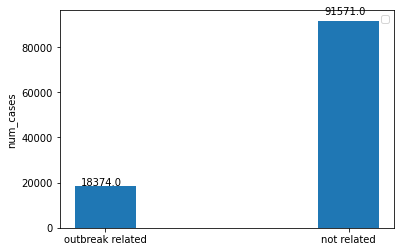

<Figure size 432x288 with 0 Axes>

In [4]:
#question 1
plot_histogram(data)

In [5]:
#question 2
clean_data = numeric_missing_value(data)

normalised = normalisation(clean_data)

print(Counter(normalised['outbreak_related']))
y = normalised['outbreak_related'].astype(int).to_numpy()
normalised.drop(columns=['outbreak_related'], inplace=True)

one_hot_encoded = handle_categorical_attributes(normalised)

Counter({False: 91571, True: 18374})


In [6]:
#get values
X = one_hot_encoded.to_numpy()

#feature selection
sel = SelectKBest(chi2, k=2)
new_X = sel.fit_transform(X, y)

#split to training and testing set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(new_X, y)
for train_index, test_index in sss.split(new_X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print('Training set brefore near missing {}'.format(Counter(y_train)))
print('Testing set brefore near missing {}'.format(Counter(y_test)))

#near miss algorithm
nm = NearMiss()
X_train_miss, y_train_miss = nm.fit_resample(X_train, y_train)

print('Training set {}'.format(Counter(y_train_miss)))
print('Testing set {}'.format(Counter(y_test)))

Training set brefore near missing Counter({0: 73257, 1: 14699})
Testing set brefore near missing Counter({0: 18314, 1: 3675})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training set Counter({0: 14699, 1: 14699})
Testing set Counter({0: 18314, 1: 3675})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [7]:
#show first 5 lines
print(one_hot_encoded.head())
#show attributes
for col in one_hot_encoded.columns:
    print(col)

   retail_and_recreation  ...  acquisition_group_UNSPECIFIED EPI LINK
0               0.613208  ...                                       0
1               0.613208  ...                                       0
2               0.613208  ...                                       0
3               0.613208  ...                                       0
4               0.613208  ...                                       0

[5 rows x 21 columns]
retail_and_recreation
grocery
parks
transit_station
workplaces
age_group_20s
age_group_30s
age_group_40s
age_group_50s
age_group_60s
age_group_70s
age_group_80s
age_group_90+
age_group_<20
age_group_UNKNOWN
acquisition_group_CC
acquisition_group_MISSING INFORMATION
acquisition_group_NO KNOWN EPI LINK
acquisition_group_OB
acquisition_group_TRAVEL
acquisition_group_UNSPECIFIED EPI LINK


In [10]:
#Decision tree
start =time.perf_counter()
dt = DecisionTreeClassifier(max_depth=2, criterion='entropy')
dt.fit(X_train_miss, y_train_miss)
end = time.perf_counter()

# Now that our classifier is trained, it is time to test it with the testing data. Because our data is imbalanced, we should loom at precision and recall, rather than accuracy.
y_pred = dt.predict(X_test)
accuracy=accuracy_score(y_pred, y_test)*100
recall = recall_score(y_pred, y_test) * 100
precision = precision_score(y_pred, y_test) * 100
print("accuracy of decision tree {:.2f} %".format(accuracy))
print("precision of Decision Tree {:.2f} %".format(precision))
print("Recall of Decision Tree {:.2f} %".format(recall))
print('Time to construct decision tree: %s Seconds'%(end-start))

accuracy of decision tree 96.04 %
precision of Decision Tree 78.37 %
Recall of Decision Tree 97.43 %
Time to construct decision tree: 0.026642885000001115 Seconds


In [ ]:
#random forest
start =time.perf_counter()
clf = RandomForestClassifier(n_estimators=100,max_depth=1, 
                             random_state=0,min_samples_split=8)
clf.fit(X_train_miss, y_train_miss)
end = time.perf_counter()

y_pred = clf.predict(X_test)
accuracy=accuracy_score(y_pred, y_test)*100
recall = recall_score(y_pred, y_test) * 100
precision = precision_score(y_pred, y_test) * 100
print("accuracy of random forest {:.2f} %".format(accuracy))
print("precision of random forest {:.2f} %".format(precision))
print("Recall of random forest {:.2f} %".format(recall))
print('Time to construct random forest: %s Seconds'%(end-start))

accuracy of random forest 89.35 %
precision of random forest 79.10 %
Recall of random forest 64.89 %
Time to construct random forest: 0.29641401800017775 Seconds


In [ ]:
#Gradient Boosting
start =time.perf_counter()
gb = GradientBoostingClassifier(n_estimators=1, learning_rate=1.0, max_depth=1, random_state=0)
gb.fit(X_train_miss, y_train_miss)
end = time.perf_counter()

y_pred = gb.predict(X_test)
accuracy=accuracy_score(y_pred, y_test)*100
recall = recall_score(y_pred, y_test) * 100
precision = precision_score(y_pred, y_test) * 100
print("accuracy of gradient boosting {:.2f} %".format(accuracy))
print("precision of gradient boosting {:.2f} %".format(precision))
print("Recall of gradient boosting {:.2f} %".format(recall))
print('Time to construct gradient boosting: %s Seconds'%(end-start))

accuracy of gradient boosting 96.04 %
precision of gradient boosting 78.37 %
Recall of gradient boosting 97.43 %
Time to construct gradient boosting: 0.011141214999952354 Seconds
